In [1]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim
import torch.utils.data as utils

import torch.nn.functional as F
from torch import nn
import torch

windowSize=50
n_fft=2048
hopLength=256

In [2]:
y, sr = librosa.load('4Beats2MelLong4.wav')

In [3]:
D = np.array(librosa.stft(y,n_fft=n_fft,hop_length=hopLength))
del y

In [4]:
midiArray=[]
HopSize=hopLength/sr
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2MelLong4.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiArray=np.array(midiArray)

In [5]:
minLength = min(midiArray.shape[0],D.T.shape[0])
midiArray=midiArray[:minLength];
D_data=np.array([np.append(np.float32(elem.real), np.float32(elem.imag)) for elem in D.T[:midiArray.shape[0]]])

In [6]:
print(D.T.shape,midiArray.shape)
print(midiArray.shape,D_data.shape)
print(midiArray.dtype,D_data.dtype)

(141258, 1025) (141145, 128)
(141145, 128) (141145, 2050)
float64 float32


In [7]:
outPutMidiArray=[]
for i in range(midiArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(windowSize)) #int(j-(np.floor(windowSize/2))) #int(j-(windowSize)) 
        val = i+val
        if(val<0 or val+1>midiArray.shape[0]):
             temp.append(np.zeros(midiArray.shape[1]))
        else:
            temp.append(midiArray[val])
    outPutMidiArray.append(temp)
outPutMidiArray=np.array(outPutMidiArray)
del midiArray

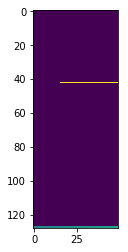

In [8]:
plt.imshow(outPutMidiArray[550].T)

In [9]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(128*windowSize, 128*2)
        self.fc2 = nn.Linear(128*2, 10000)
        self.fc4 = nn.Linear(10000, n_fft+2)

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10000, bias=True)
  (fc4): Linear(in_features=10000, out_features=2050, bias=True)
)

In [10]:
del D
tensor_x = torch.stack([torch.Tensor(i) for i in outPutMidiArray]) # transform to torch tensors
del outPutMidiArray
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
del D_data
tensor_x = tensor_x.view(tensor_x.shape[0],-1)
print(tensor_x.shape,tensor_y.shape)
my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset

train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

my_dataloader = utils.DataLoader(train_dataset,batch_size=128,shuffle=False) # create your dataloader
my_validationloader = utils.DataLoader(test_dataset,batch_size=128,shuffle=False) # create your dataloader

print(len(my_dataloader),len(my_validationloader))

my_testloader = utils.DataLoader(my_dataset) # create your dataloader


# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

criterion = nn.MSELoss()
# or criterion = nn.MSELoss()
# Get our data


torch.Size([141145, 6400]) torch.Size([141145, 2050])
883 221


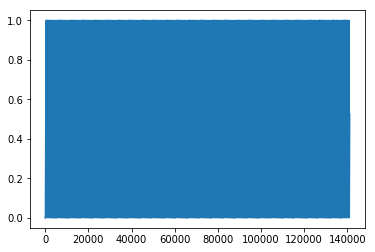

In [11]:
plt.plot(tensor_x.numpy()[:,127])
plt.show()

In [12]:
##Reset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Counter=0;
LossOverEpoch=[]
EvalLoss=[]
model.train()
model.to(device)

Network(
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10000, bias=True)
  (fc4): Linear(in_features=10000, out_features=2050, bias=True)
)

In [20]:
epochs = 250
for i in range(epochs):
    running_loss = 0
    model.train()
    for data, labels in my_dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()     
        logits = model(data)
        loss =criterion(logits,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval();
    evalLossNum=0
    generateAudio('4Beats2Mel.mid','./generatedData-v2/'+str(Counter))
    for data, labels in my_validationloader:
        data, labels = data.to(device), labels.to(device)
        pred= model(data)
        loss = criterion(pred,labels)
        evalLossNum += loss.item()
    LossOverEpoch.append(running_loss/len(my_dataloader))
    EvalLoss.append(evalLossNum/len(my_validationloader))
    print(str(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter))+"  "+str(evalLossNum/len(my_validationloader)))
    Counter+=1

generating audio and Spectrum image
Training loss: 0.5361722554517899   84  0.557414142659347
generating audio and Spectrum image
Training loss: 0.5349436958878389   85  0.5532809042822722
generating audio and Spectrum image
Training loss: 0.5340004158992054   86  0.5525565620730905
generating audio and Spectrum image
Training loss: 0.5322887508677464   87  0.5526318190054657
generating audio and Spectrum image
Training loss: 0.5308839411792237   88  0.5523842523270602
generating audio and Spectrum image
Training loss: 0.5294132388259114   89  0.5491972743655762
generating audio and Spectrum image
Training loss: 0.5279452490239559   90  0.5499544549581692
generating audio and Spectrum image
Training loss: 0.5271329625614097   91  0.548605718494001
generating audio and Spectrum image
Training loss: 0.5259297673726541   92  0.5481210407628193
generating audio and Spectrum image
Training loss: 0.5253021991468907   93  0.5472177298090577
generating audio and Spectrum image
Training loss: 0

Training loss: 0.47036176525047924   169  0.5098662938737222
generating audio and Spectrum image
Training loss: 0.4698835316695281   170  0.5105285202216239
generating audio and Spectrum image
Training loss: 0.4694728342181289   171  0.5097243953074805
generating audio and Spectrum image
Training loss: 0.46906789691774925   172  0.511439159714798
generating audio and Spectrum image
Training loss: 0.46877109619661206   173  0.5114614324332363
generating audio and Spectrum image
Training loss: 0.4684132986943557   174  0.5133498071005981
generating audio and Spectrum image
Training loss: 0.46806749888819177   175  0.5149830284431509
generating audio and Spectrum image
Training loss: 0.46762592734458897   176  0.5166330367191885
generating audio and Spectrum image
Training loss: 0.4675099886152239   177  0.5169508581247805
generating audio and Spectrum image
Training loss: 0.4671719285025602   178  0.5222523728916548
generating audio and Spectrum image
Training loss: 0.4666243199415142   

generating audio and Spectrum image
Training loss: 0.44354376399368556   255  0.5021484028969415
generating audio and Spectrum image
Training loss: 0.4433202027498258   256  0.5030854557434358
generating audio and Spectrum image
Training loss: 0.44309633730626996   257  0.502509406654004
generating audio and Spectrum image
Training loss: 0.44270070199248207   258  0.5025391617781436
generating audio and Spectrum image
Training loss: 0.44242839481457985   259  0.5026276185771459
generating audio and Spectrum image
Training loss: 0.4421224508894394   260  0.5031643364224498
generating audio and Spectrum image
Training loss: 0.44173154452581503   261  0.5047424485510831
generating audio and Spectrum image
Training loss: 0.4413433711499077   262  0.5036533341418564
generating audio and Spectrum image
Training loss: 0.44080129743364904   263  0.5037661275712613
generating audio and Spectrum image
Training loss: 0.4403307948552604   264  0.5021296397053818
generating audio and Spectrum image

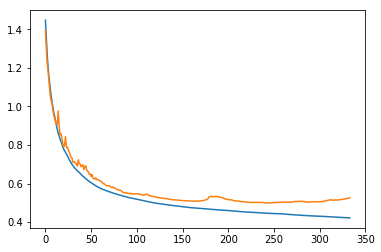

In [21]:
plt.plot(LossOverEpoch)
plt.plot(EvalLoss)
plt.show()
torch.save(model.state_dict(), './w50-128*2-256-10000-2050-50Epochs.model')

In [ ]:
model.eval()
outputArray=[]
for data, labels in my_testloader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray)

In [ ]:
plt.imshow(outputArray.T)
plt.tight_layout()

In [ ]:
transformedArray=[]
for elem in outputArray:
    a=np.array(np.int((n_fft/2+1)) *[1+1j])
    a.real=elem[:np.int(n_fft/2+1)]
    a.imag=elem[np.int(n_fft/2+1):]
    transformedArray.append(a)
transformedArray=np.array(transformedArray).T

In [ ]:
print((transformedArray).shape)
Y_infered = librosa.istft(transformedArray,hop_length=hopLength)

In [ ]:
ipd.Audio(Y_infered,rate=sr)

In [ ]:
ipd.Audio(y,rate=sr)

In [ ]:

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(D.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy()[:,:1025].T,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [ ]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        output = model.forward(test)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

In [ ]:
plt.imshow(outPutMidiArray[60].T)
plt.show()

In [ ]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))

MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray,hop_length=hopLength) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

In [ ]:
librosa.display.waveplot(y[:500], sr=sr);

In [13]:
def generateAudio(stringInput,fileName):
    print("generating audio and Spectrum image")
    midiTestArray=[]
    HopSize=0.023
    timeTracker=0.0
    totalTimeTracker=0.0
    MemoryArray=np.zeros(128)
    lasttime=0;
    bpm=60
    for msg in mido.MidiFile(stringInput):#'4Beats2Mel.mid'
        if not msg.is_meta:
            totalTimeTracker+=msg.time
            nextEventTime=lasttime+msg.time
            while nextEventTime> timeTracker + HopSize:
                MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
                midiTestArray.append(MemoryArray.copy())
                timeTracker += HopSize;
            if msg.type=='note_on':
                MemoryArray[msg.note]+=1.0;
            elif msg.type=='note_off':
                MemoryArray[msg.note]-=1.0;
            if(timeTracker+msg.time >= timeTracker + HopSize):
                MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
                midiTestArray.append(MemoryArray.copy())
                timeTracker += HopSize
            lasttime += msg.time
        else:
            if(msg.type == 'set_tempo'):
                bpm=60000000/msg.tempo
    midiTestArray = np.float32(np.array(midiTestArray))
    MainMidiTest=[]
    for i in range(midiTestArray.shape[0]):
        temp=[]
        for j in range(windowSize):
            val = int(j-(np.floor(windowSize/2)))
            val = i+val
            if(val<0 or val+1>midiTestArray.shape[0]):
                 temp.append(np.zeros(midiTestArray.shape[1]))
            else:
                temp.append(midiTestArray[val])
        MainMidiTest.append(temp)
    MainMidiTest=np.array(MainMidiTest)
    tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
    tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)
    testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
    TestLoader = utils.DataLoader(testDataSet) # create your dataloader
    model.eval()
    outputArray=[]
    for data, labels in TestLoader:
        with torch.no_grad():
            data, labels = data.to(device), labels.to(device)
            output = model.forward(data)
            outputArray.append(output[0].cpu().numpy())
    outputArray=np.array(outputArray)
    transformedArray=[]
    for elem in outputArray:
        a=np.array(np.int((n_fft/2+1)) *[1+1j])
        a.real=elem[:np.int(n_fft/2+1)]
        a.imag=elem[np.int(n_fft/2+1):]
        transformedArray.append(a)
    transformedArray=np.array(transformedArray).T
    Y_infered2 = librosa.istft(transformedArray,hop_length=hopLength) 
    plt.figure(figsize=(20,10))
    
    librosa.display.specshow(librosa.amplitude_to_db(transformedArray.real,
                                                      ref=np.max),
                              y_axis='log', x_axis='time')
    plt.title('Power spectrogram  ' + str(Counter) )
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()


    #plt.show();
    plt.savefig(fileName+'.png')
    librosa.output.write_wav(fileName+'.wav', Y_infered2, sr)
    plt.close();

In [14]:
generateAudio('4Beats2Mel.mid','./generatedData/'+str(Counter))

generating audio and Spectrum image
